In this notebook I will implement a long short term memory (LSTM) neural network to predict the closing stock price of a corporation (Apple) using the past 60 day stock price.

In [62]:
# Import libraries
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.io as pio
plt.style.use('fivethirtyeight')

In [63]:
# get the stock quote
df = yf.Ticker('AAPL').history(period='10y')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-08-18 00:00:00-04:00,21.862495,22.057836,21.749288,22.011221,190288000,0.00,0.0
2014-08-19 00:00:00-04:00,22.066721,22.348631,22.046743,22.315334,277596000,0.00,0.0
2014-08-20 00:00:00-04:00,22.295351,22.439634,22.186581,22.324207,210796000,0.00,0.0
2014-08-21 00:00:00-04:00,22.324209,22.406341,22.222100,22.326429,133912000,0.00,0.0
2014-08-22 00:00:00-04:00,22.262054,22.523987,22.239857,22.490690,176736000,0.00,0.0
...,...,...,...,...,...,...,...
2024-08-12 00:00:00-04:00,216.070007,219.509995,215.600006,217.529999,38028100,0.25,0.0
2024-08-13 00:00:00-04:00,219.009995,221.889999,219.009995,221.270004,44155300,0.00,0.0
2024-08-14 00:00:00-04:00,220.570007,223.029999,219.699997,221.720001,41960600,0.00,0.0


In [64]:
df.shape

(2517, 7)

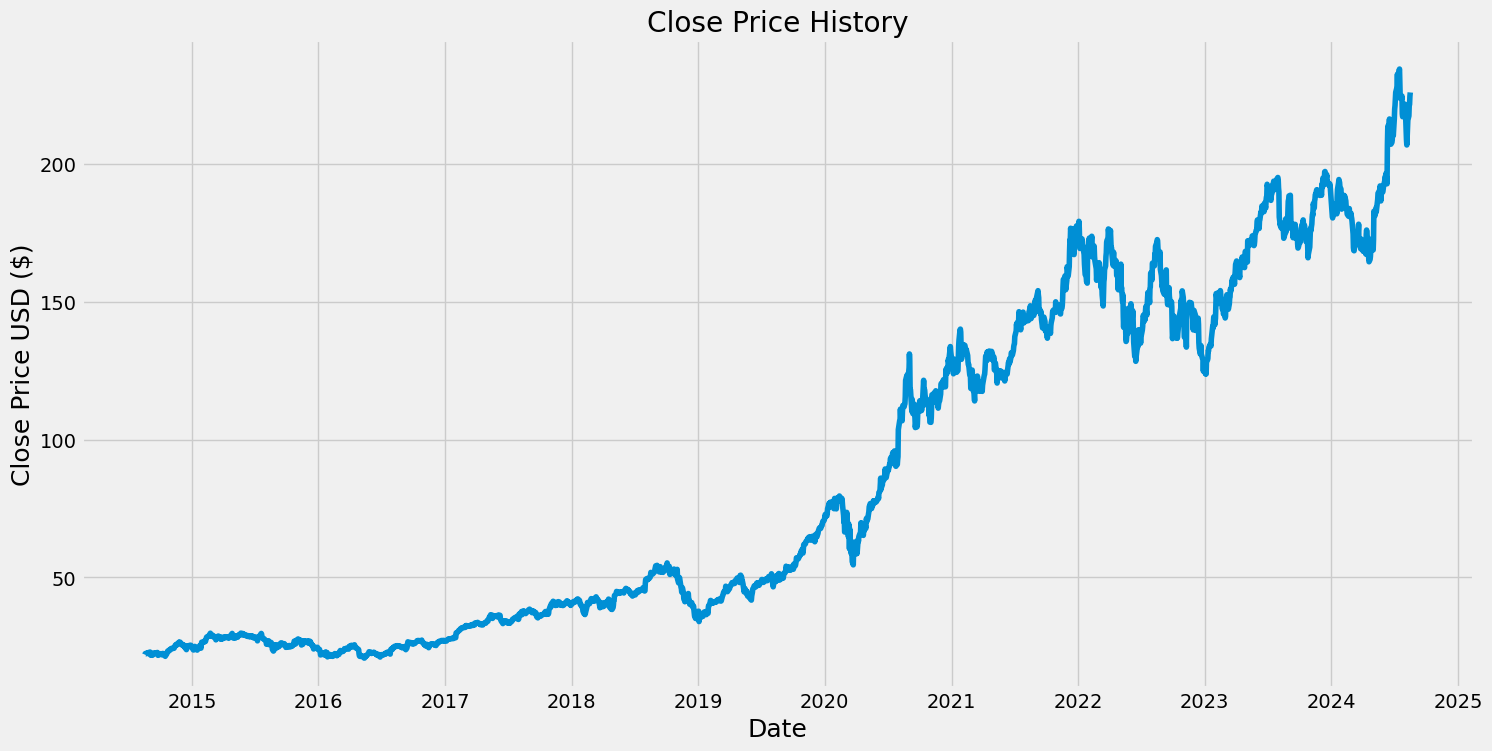

In [65]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [66]:
# Create a new data frame with only the 'Close' column
data = df[['Close']]

# convert to numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

2014

In [67]:
# scale the data
scaler = StandardScaler() # In the video he uses MinMaxScaler, but I believe StandardScaler is more appropriate
# because stocks prices are not bound to a specific range
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[-1.05544942],
       [-1.05047715],
       [-1.05033207],
       ...,
       [ 2.20980015],
       [ 2.25885031],
       [ 2.28059592]])

In [68]:
# create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])



In [69]:
# convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [70]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1954, 60, 1)

In [71]:
# build the lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

c:\Users\jsull\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [72]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [73]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - loss: 0.0352
Epoch 2/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 0.0036
Epoch 3/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 0.0020
Epoch 4/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 0.0017
Epoch 5/5
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 0.0014


In [74]:
# create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
# create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


In [75]:
# convert the data to a numpy array
x_test = np.array(x_test)

In [76]:
# Reshape the data to 3D
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [77]:
# get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [78]:
# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

6.419532563529953

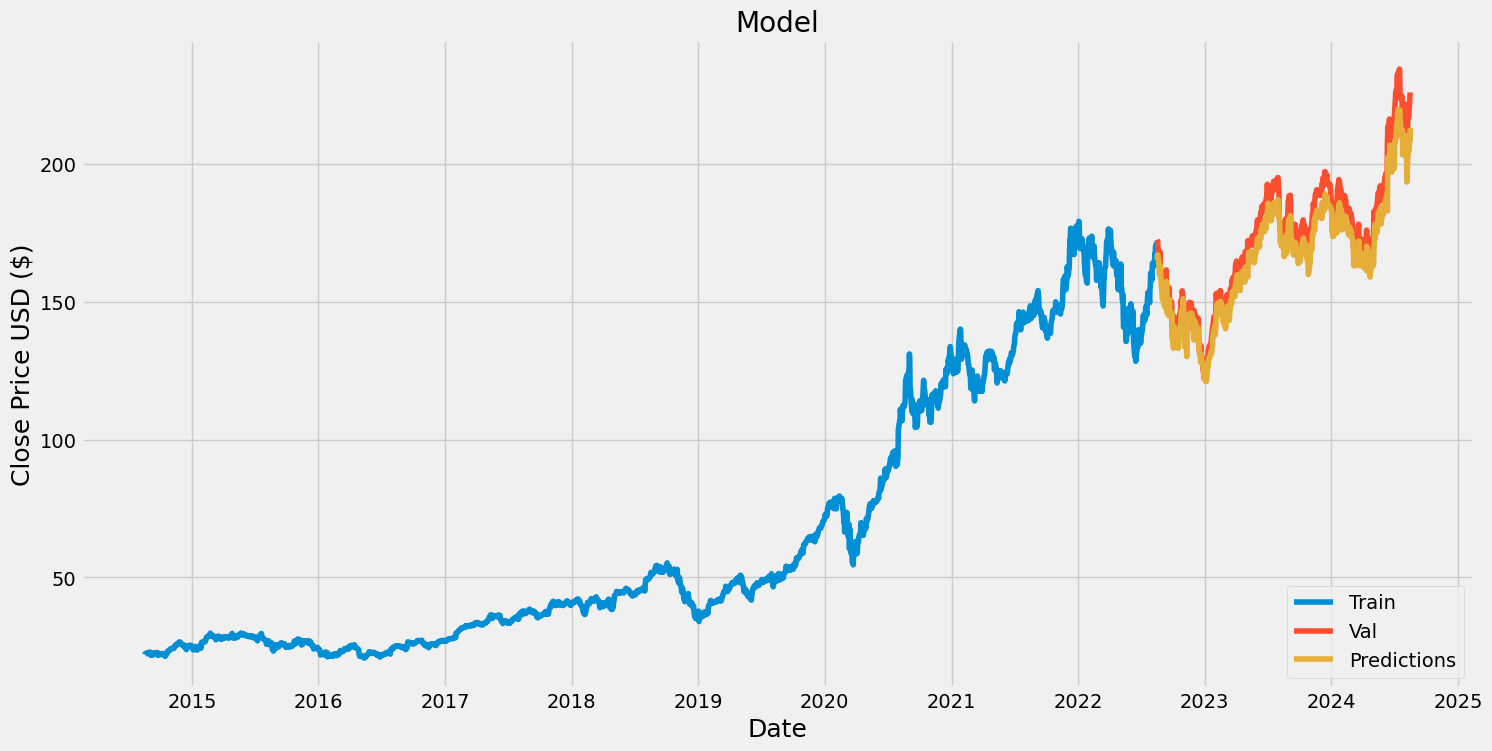

In [79]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

pred_chart = plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
_ = plt.show()

In [80]:
plotly_fig = tls.mpl_to_plotly(pred_chart)
pio.show(plotly_fig)

c:\Users\jsull\anaconda3\Lib\site-packages\plotly\matplotlylib\renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [96]:
valid['returns'] = np.log(valid["Close"]).diff()
valid['pred_returns'] = np.log(valid["Predictions"]).diff()
valid['position'] = np.where(valid.pred_returns > 0, 1, np.nan)
valid['position'] = np.where(valid.pred_returns < 0, -1, valid['position'])
valid['strat_return'] = valid['returns'] * valid['position'].shift()
valid

,Close,Predictions,returns,pred_returns,position,strat_return
Date,,,,,,
2022-08-17 00:00:00-04:00,172.637207,165.333679,NaN,NaN,NaN,NaN
2022-08-18 00:00:00-04:00,172.241592,167.124924,-0.002294,0.010776,1.0,NaN
2022-08-19 00:00:00-04:00,169.640396,166.188828,-0.015217,-0.005617,-1.0,-0.015217
2022-08-22 00:00:00-04:00,165.733704,163.533875,-0.023299,-0.016105,-1.0,0.023299
2022-08-23 00:00:00-04:00,165.397430,159.888824,-0.002031,-0.022542,-1.0,0.002031
...,...,...,...,...,...,...
2024-08-12 00:00:00-04:00,217.529999,204.915512,0.007105,0.008938,1.0,0.007105
2024-08-13 00:00:00-04:00,221.270004,205.792343,0.017047,0.004270,1.0,0.017047
2024-08-14 00:00:00-04:00,221.720001,210.060287,0.002032,0.020527,1.0,0.002032


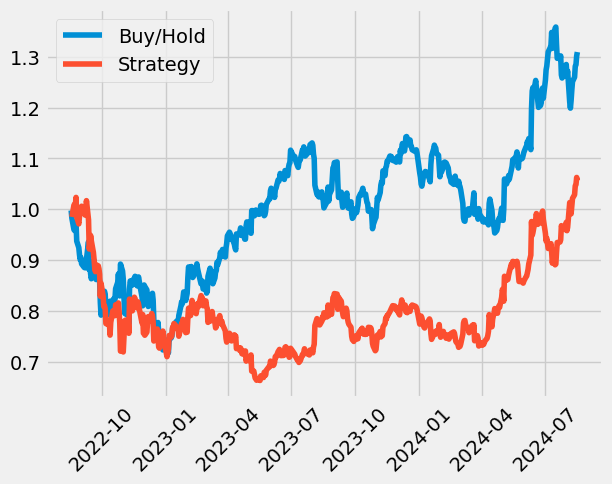

In [97]:
plt.plot(np.exp(valid['returns'].dropna()).cumprod(), label='Buy/Hold')
plt.plot(np.exp(valid['strat_return'].dropna()).cumprod(), label='Strategy')
plt.xticks(rotation=45)
plt.legend();

In [81]:
# show the valid and predicted prices
valid

,Close,Predictions
Date,,
2022-08-17 00:00:00-04:00,172.637207,165.333679
2022-08-18 00:00:00-04:00,172.241592,167.124924
2022-08-19 00:00:00-04:00,169.640396,166.188828
2022-08-22 00:00:00-04:00,165.733704,163.533875
2022-08-23 00:00:00-04:00,165.397430,159.888824
...,...,...
2024-08-12 00:00:00-04:00,217.529999,204.915512
2024-08-13 00:00:00-04:00,221.270004,205.792343
2024-08-14 00:00:00-04:00,221.720001,210.060287


In [82]:
# get the quote
apple_quote = yf.Ticker('AAPL').history(period='10y')
# create a new dataframe
new_df = apple_quote.filter(['Close'])
# get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
# standard scale the data
last_60_days_scaled = scaler.transform(last_60_days)
# create an empty list
X_test = []
# append the past 60 days
X_test.append(last_60_days_scaled)
# convert the X_test data set to a numpy array
X_test = np.array(X_test)
# reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# get the predicted scaled price
pred_price = model.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)
pred_price

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[212.44742]], dtype=float32)

In [83]:
apple_quote2 = yf.Ticker('AAPL').history(period='1d')
apple_quote2['Close']

Date
2024-08-16 00:00:00-04:00    226.050003
Name: Close, dtype: float64